In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

df = pd.read_csv('Data Final_Employee Attrition.csv')
df = df.rename(columns={'BusinessTravel':'Business Travel'})
import re
df = df.rename(columns=lambda col: re.sub(r"\s+", "_", col.lower()))
first_column = 'employee_number'
df = pd.concat([df[first_column], df.drop(columns=[first_column])], axis=1)

cont = df.select_dtypes(include=[np.number])
cont = cont.drop(columns= {'standard_hours', 'education', 'environment_satisfaction', 'job_involvement', 'job_level', 'job_satisfaction', 'performance_rating', 'relationship_satisfaction', 'stock_option_level', 'work_life_balance'}, axis=1)

#Define the catagorical columns
cat = df.drop(cont, axis=1)
cat

,attrition,business_travel,department,education,education_field,environment_satisfaction,gender,job_involvement,job_level,job_role,job_satisfaction,marital_status,over_18,over_time,performance_rating,relationship_satisfaction,standard_hours,stock_option_level,work_life_balance
0,Yes,Travel_Rarely,Sales,2,Life Sciences,2,Female,3,2,Sales Executive,4,Single,Y,Yes,3,1,80,0,1
1,No,Travel_Frequently,Research & Development,1,Life Sciences,3,Male,2,2,Research Scientist,2,Married,Y,No,4,4,80,1,3
2,Yes,Travel_Rarely,Research & Development,2,Other,4,Male,2,1,Laboratory Technician,3,Single,Y,Yes,3,2,80,0,3
3,No,Travel_Frequently,Research & Development,4,Life Sciences,4,Female,3,1,Research Scientist,3,Married,Y,Yes,3,3,80,0,3
4,No,Travel_Rarely,Research & Development,1,Medical,1,Male,3,1,Laboratory Technician,2,Married,Y,No,3,4,80,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,No,Travel_Frequently,Research & Development,2,Medical,3,Male,4,2,Laboratory Technician,4,Married,Y,No,3,3,80,1,3
1466,No,Travel_Rarely,Research & Development,1,Medical,4,Male,2,3,Healthcare Representative,1,Married,Y,No,3,1,80,1,3
1467,No,Travel_Rarely,Research & Development,3,Life Sciences,2,Male,4,2,Manufacturing Director,2,Married,Y,Yes,4,2,80,1,3
1468,No,Travel_Frequently,Sales,3,Medical,4,Male,2,2,Sales Executive,2,Married,Y,No,3,4,80,0,2


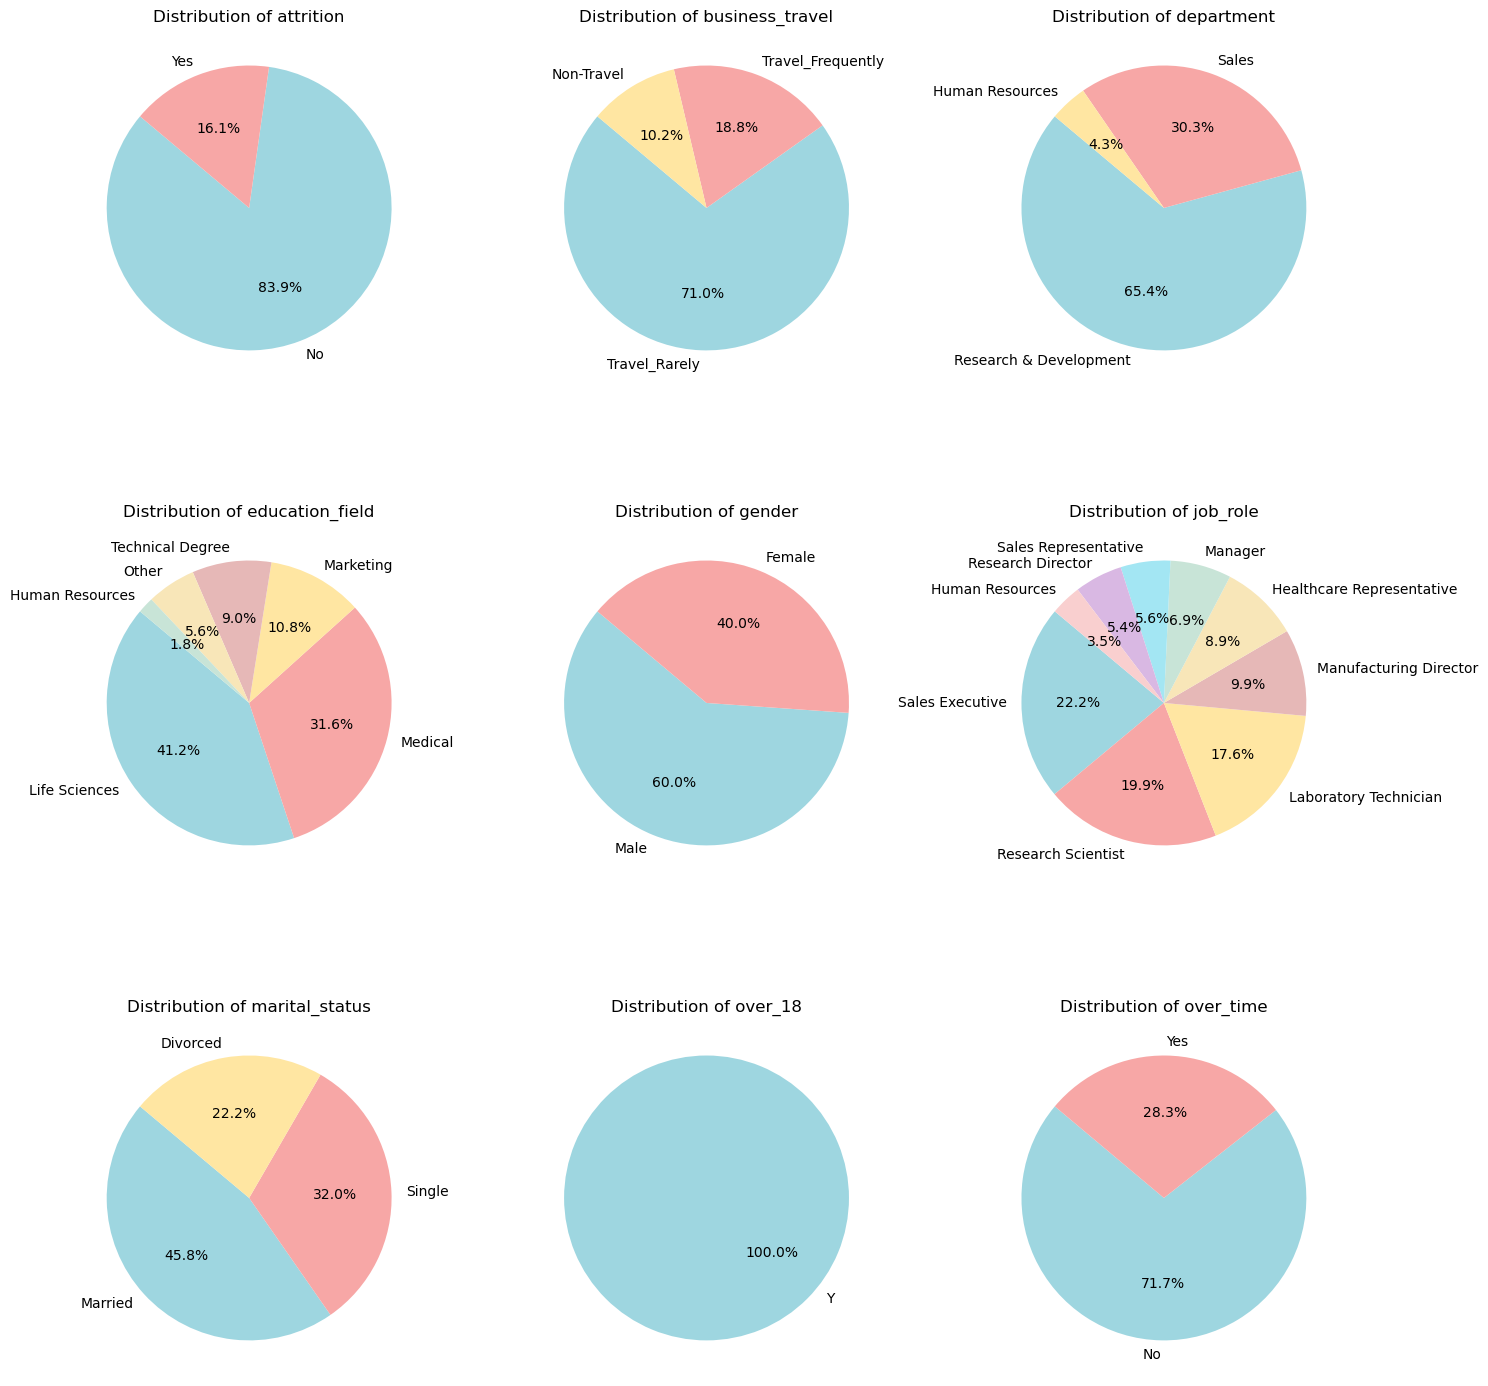

In [3]:
#Visualize Values Distribution with Pie Charts
import math
def draw_pie_charts(dataframe, columns_per_row=3):
    categorical_columns = dataframe.select_dtypes(include='object').columns
    num_columns = len(categorical_columns)
    num_rows = math.ceil(num_columns / columns_per_row)
    
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))

    blue_colors = ['#9ED6E0', '#F7A7A6', '#FFE6A2', '#E6B8B7', '#F8E6B8', '#C8E4D7', '#A3E6F3', '#D9B8E3', '#F9CFCF', '#C7E2F2']

    for i, column in enumerate(categorical_columns):
        row_idx = i // columns_per_row
        col_idx = i % columns_per_row

        counts = dataframe[column].value_counts()
        axes[row_idx, col_idx].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=blue_colors)
        axes[row_idx, col_idx].set_title(f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

draw_pie_charts(cat, columns_per_row=3)

In [4]:
#Chi-square Hypothesis Testing
from scipy.stats import chi2_contingency

categorical_vars = cat.columns.difference(['attrition'])

results = []

for var in categorical_vars:
    contingency_table = pd.crosstab(cat['attrition'], cat[var])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    result_df = pd.DataFrame({
        'Variable': [var],
        'Chi2 Statistic': [chi2],
        'df': [dof],
        'P-value': [p]
    })
    
    results.append(result_df)

results = pd.concat(results, ignore_index=True)

results['P-value'] = results['P-value'].map('{:.5f}'.format)

results

,Variable,Chi2 Statistic,df,P-value
0,business_travel,24.182414,2,0.00001
1,department,10.796007,2,0.00453
2,education,3.073961,4,0.54553
3,education_field,16.024674,5,0.00677
4,environment_satisfaction,22.503881,3,0.00005
5,gender,1.116967,1,0.29057
6,job_involvement,28.492021,3,0.00000
7,job_level,72.529013,4,0.00000
8,job_role,86.190254,8,0.00000
9,job_satisfaction,17.505077,3,0.00056


In [5]:
#Cross-tabulation between 'attrition' and the other categorical variables
cross_tabs = []

for var in categorical_vars:
    cross_tab = pd.crosstab(cat[var], cat['attrition'], margins=True, margins_name='Total', normalize='index') * 100
    cross_tab = cross_tab.round(2)
    cross_tabs.append({var: cross_tab})

for result in cross_tabs:
    for var, table in result.items():
        print(f"Cross-Tabulation for 'attrition' and '{var}' (%):")
        display(table)
        print("\n" + "=" * 20 + "\n")

Cross-Tabulation for 'attrition' and 'business_travel' (%):


attrition,No,Yes
business_travel,,
Non-Travel,92.00,8.00
Travel_Frequently,75.09,24.91
Travel_Rarely,85.04,14.96
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'department' (%):


attrition,No,Yes
department,,
Human Resources,80.95,19.05
Research & Development,86.16,13.84
Sales,79.37,20.63
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'education' (%):


attrition,No,Yes
education,,
1,81.76,18.24
2,84.40,15.60
3,82.69,17.31
4,85.43,14.57
5,89.58,10.42
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'education_field' (%):


attrition,No,Yes
education_field,,
Human Resources,74.07,25.93
Life Sciences,85.31,14.69
Marketing,77.99,22.01
Medical,86.42,13.58
Other,86.59,13.41
Technical Degree,75.76,24.24
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'environment_satisfaction' (%):


attrition,No,Yes
environment_satisfaction,,
1,74.65,25.35
2,85.02,14.98
3,86.31,13.69
4,86.55,13.45
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'gender' (%):


attrition,No,Yes
gender,,
Female,85.20,14.80
Male,82.99,17.01
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'job_involvement' (%):


attrition,No,Yes
job_involvement,,
1,66.27,33.73
2,81.07,18.93
3,85.60,14.40
4,90.97,9.03
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'job_level' (%):


attrition,No,Yes
job_level,,
1,73.66,26.34
2,90.26,9.74
3,85.32,14.68
4,95.28,4.72
5,92.75,7.25
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'job_role' (%):


attrition,No,Yes
job_role,,
Healthcare Representative,93.13,6.87
Human Resources,76.92,23.08
Laboratory Technician,76.06,23.94
Manager,95.10,4.90
Manufacturing Director,93.10,6.90
Research Director,97.50,2.50
Research Scientist,83.90,16.10
Sales Executive,82.52,17.48
Sales Representative,60.24,39.76




Cross-Tabulation for 'attrition' and 'job_satisfaction' (%):


attrition,No,Yes
job_satisfaction,,
1,77.16,22.84
2,83.57,16.43
3,83.48,16.52
4,88.67,11.33
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'marital_status' (%):


attrition,No,Yes
marital_status,,
Divorced,89.91,10.09
Married,87.52,12.48
Single,74.47,25.53
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'over_18' (%):


attrition,No,Yes
over_18,,
Y,83.88,16.12
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'over_time' (%):


attrition,No,Yes
over_time,,
No,89.56,10.44
Yes,69.47,30.53
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'performance_rating' (%):


attrition,No,Yes
performance_rating,,
3,83.92,16.08
4,83.63,16.37
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'relationship_satisfaction' (%):


attrition,No,Yes
relationship_satisfaction,,
1,79.35,20.65
2,85.15,14.85
3,84.53,15.47
4,85.19,14.81
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'standard_hours' (%):


attrition,No,Yes
standard_hours,,
80,83.88,16.12
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'stock_option_level' (%):


attrition,No,Yes
stock_option_level,,
0,75.59,24.41
1,90.60,9.40
2,92.41,7.59
3,82.35,17.65
Total,83.88,16.12




Cross-Tabulation for 'attrition' and 'work_life_balance' (%):


attrition,No,Yes
work_life_balance,,
1,68.75,31.25
2,83.14,16.86
3,85.78,14.22
4,82.35,17.65
Total,83.88,16.12


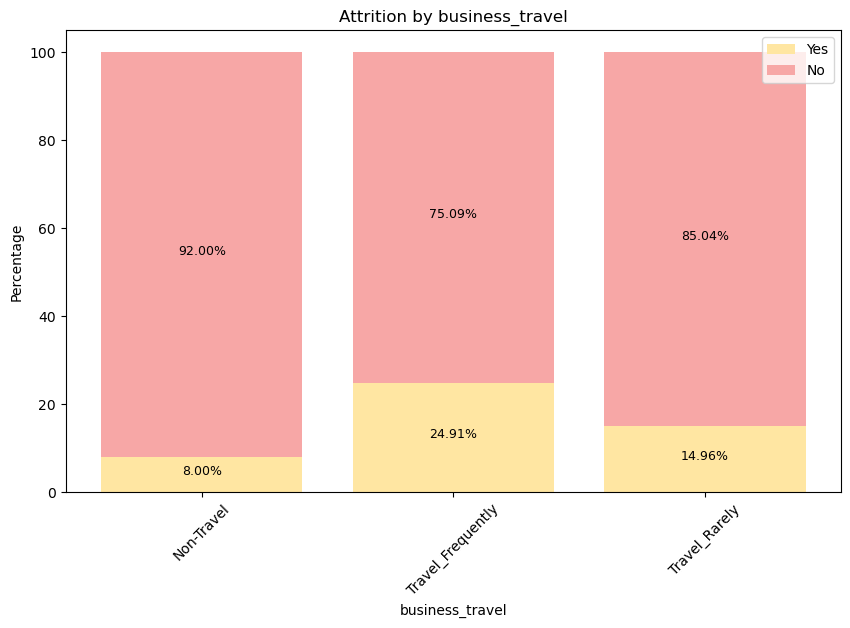

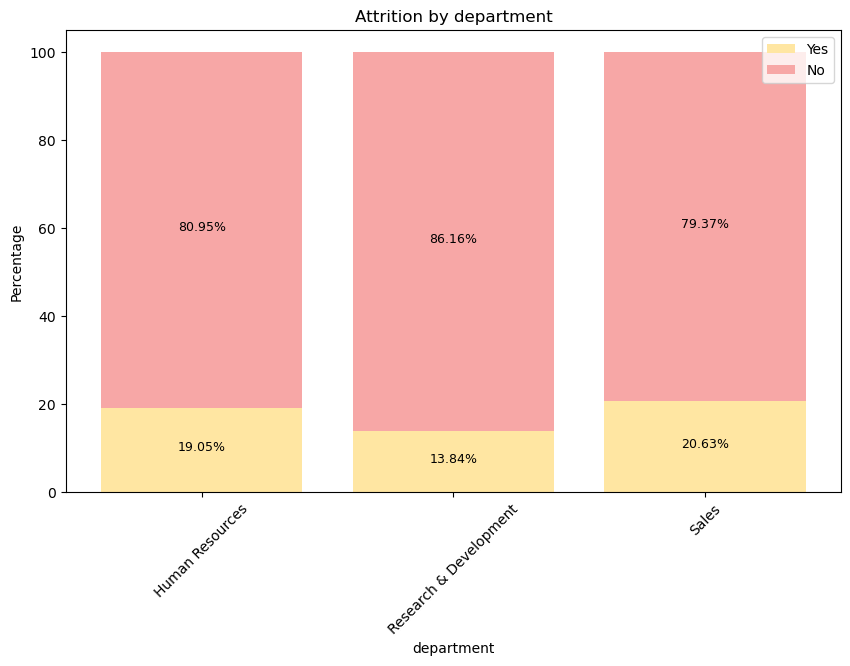

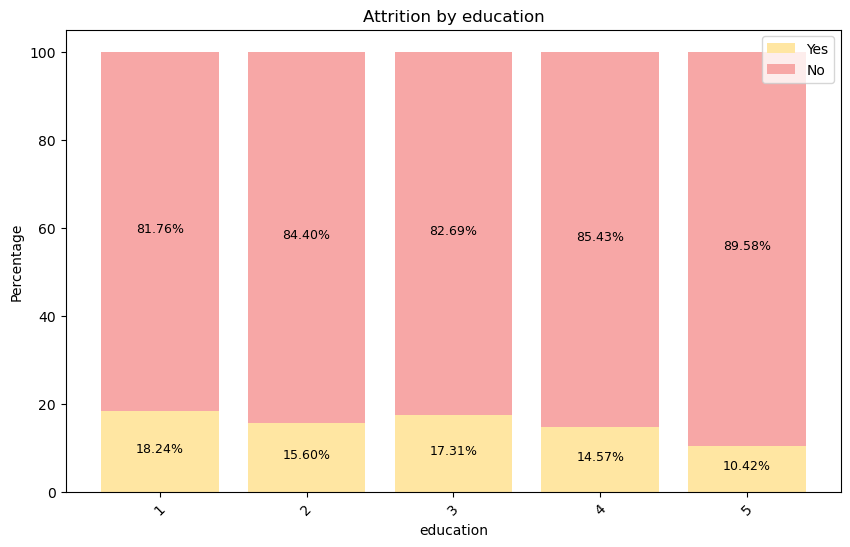

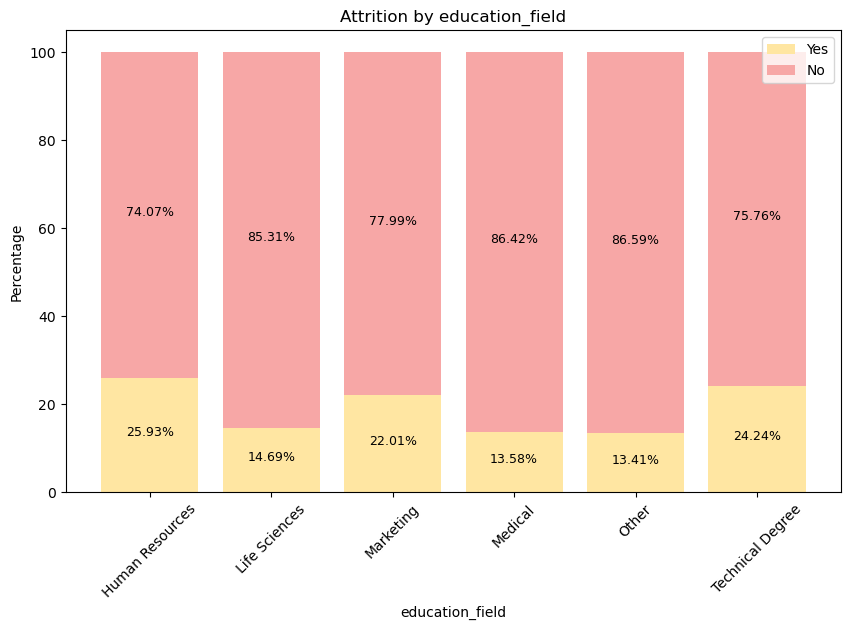

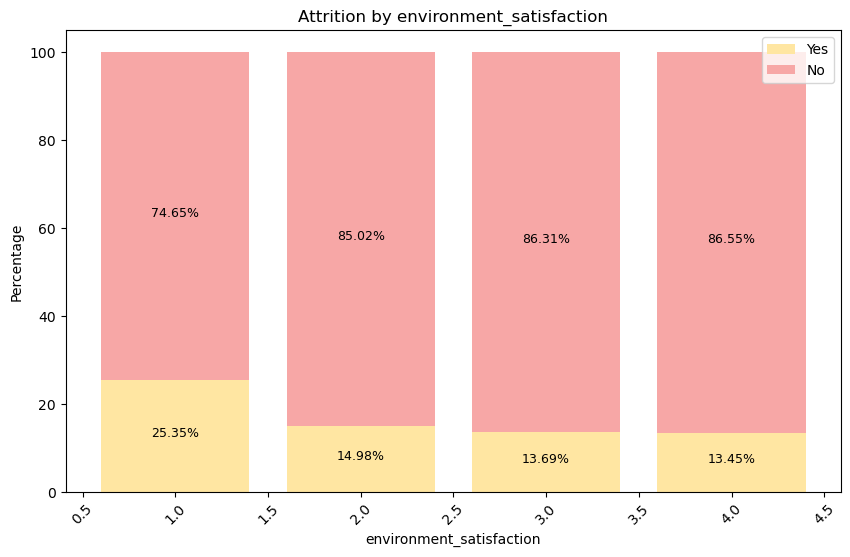

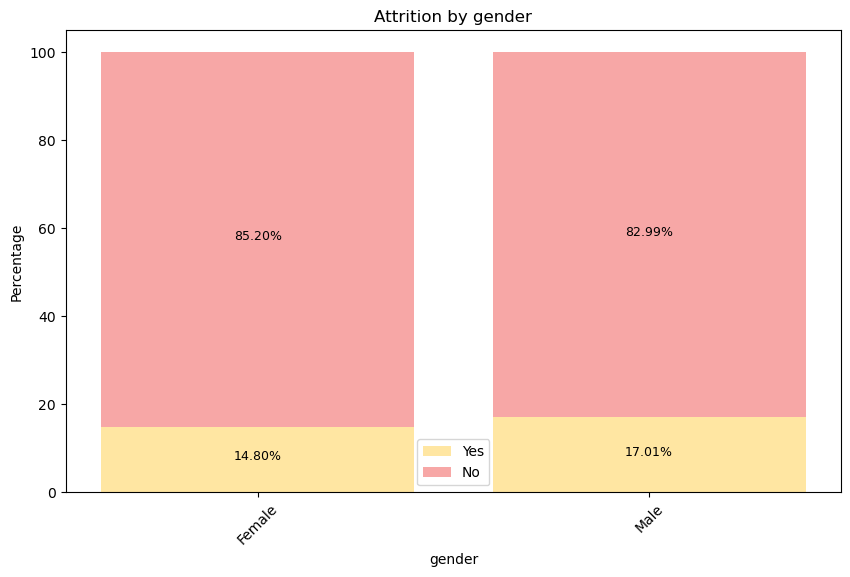

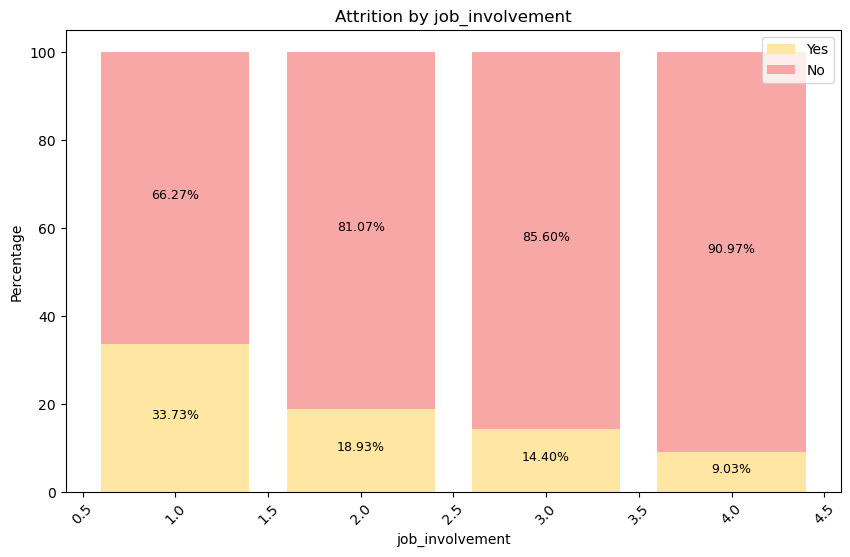

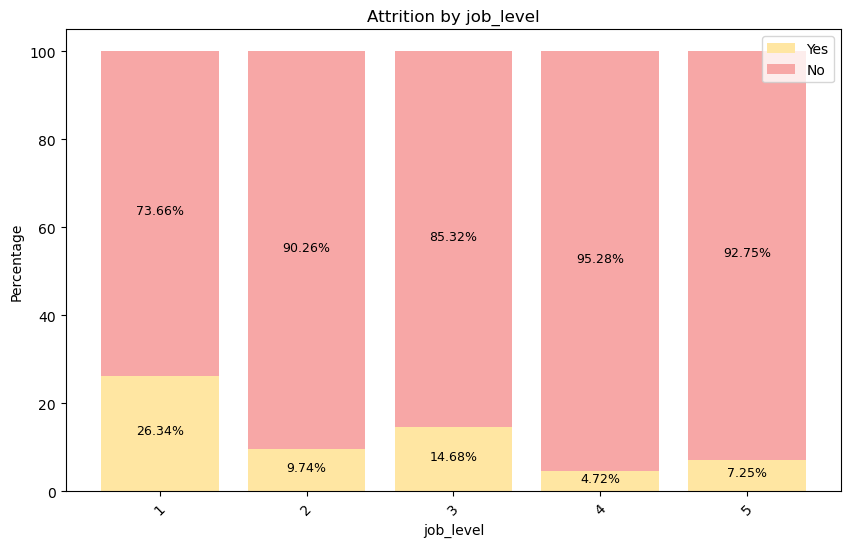

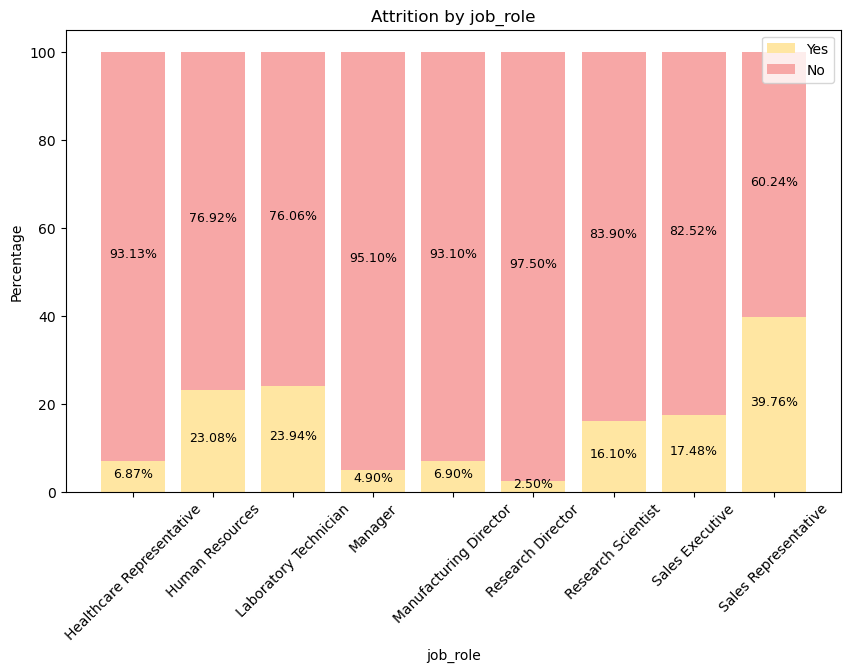

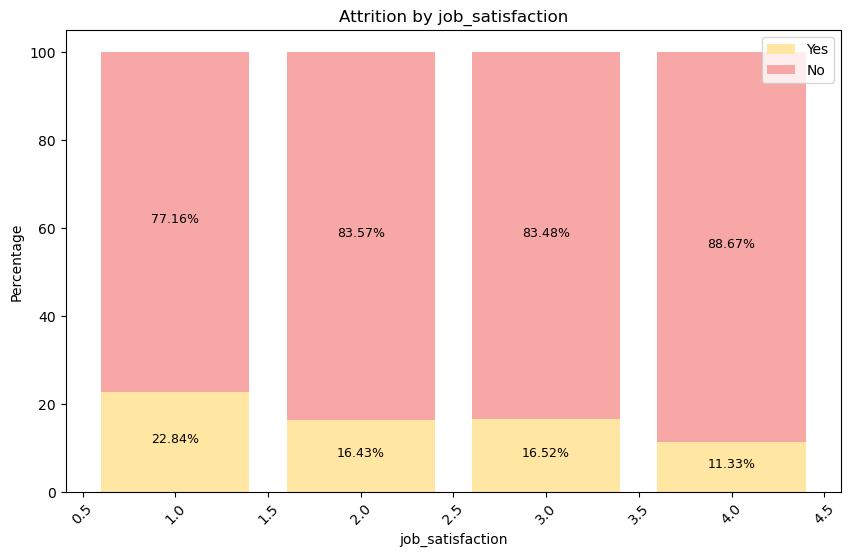

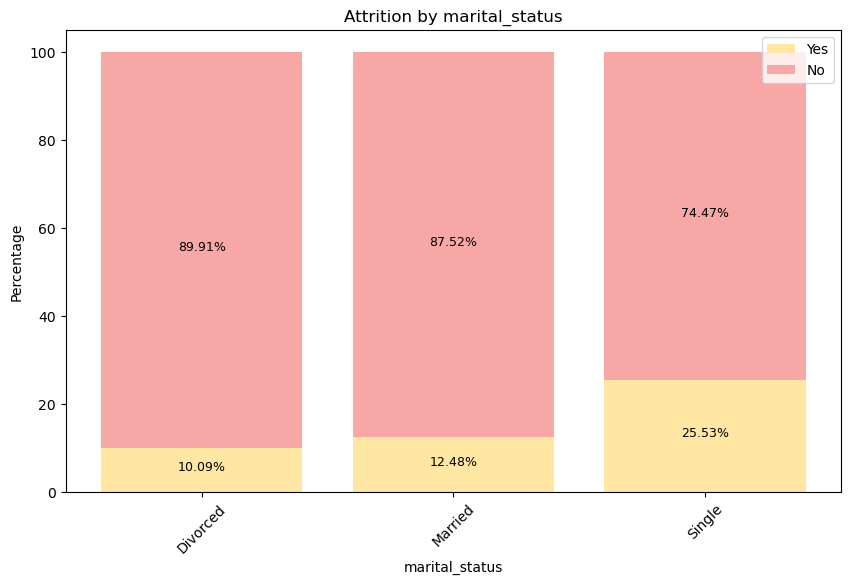

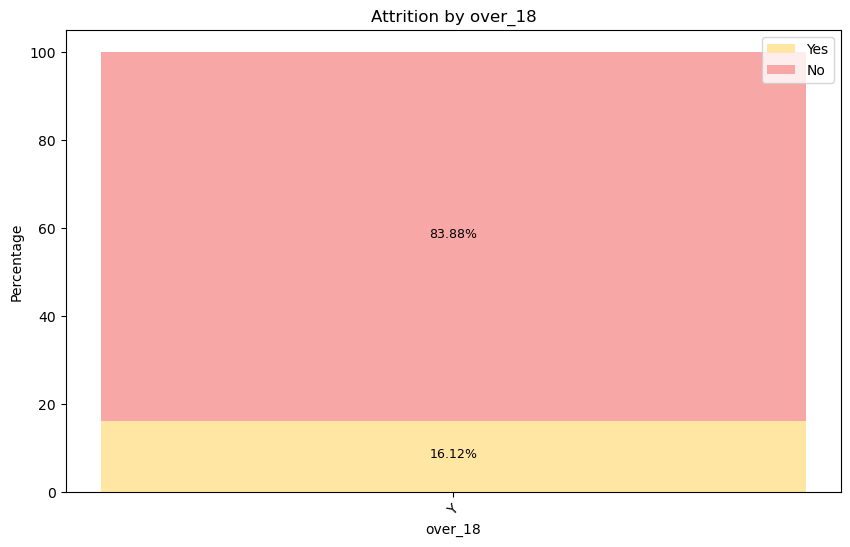

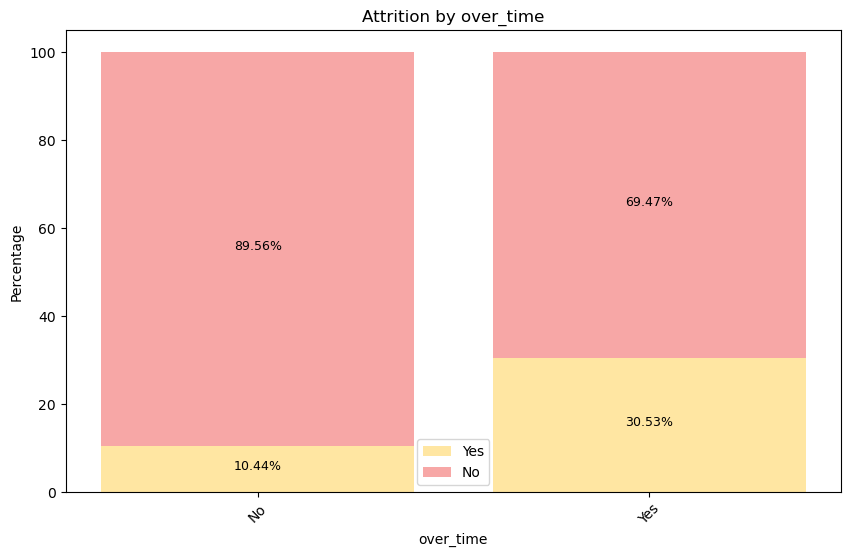

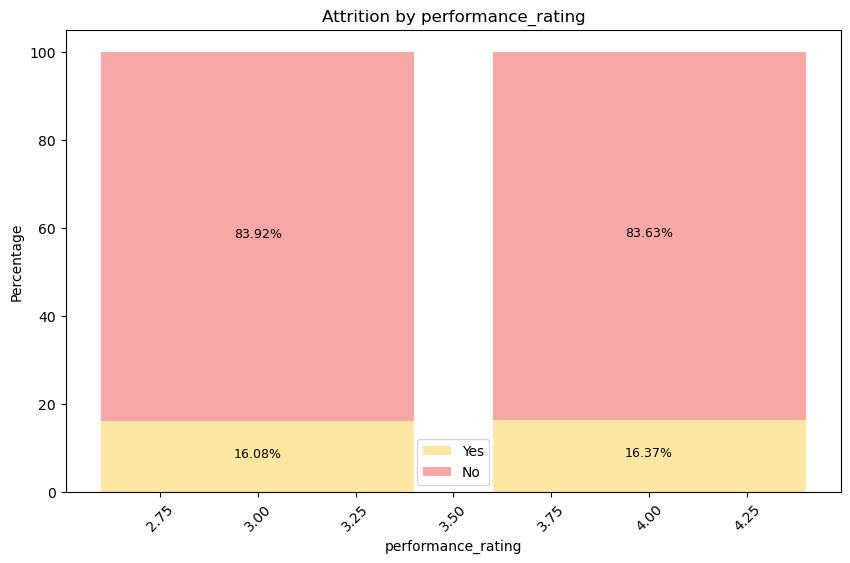

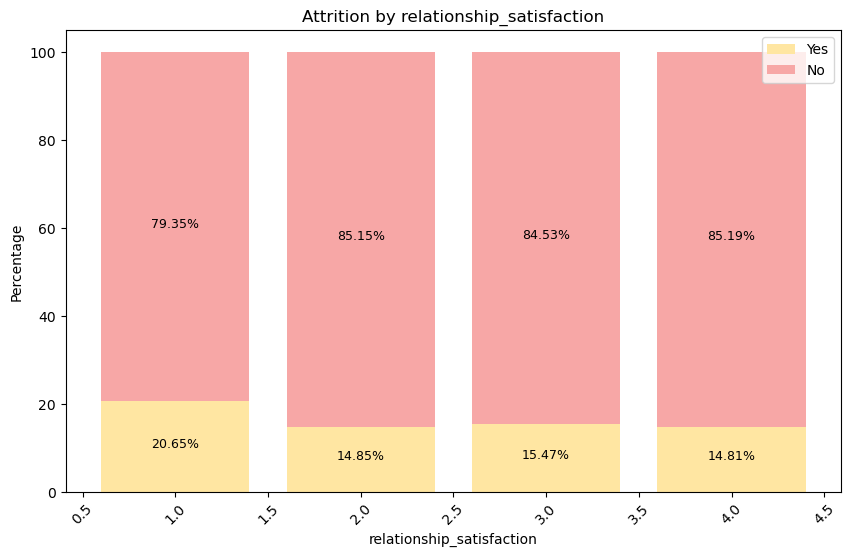

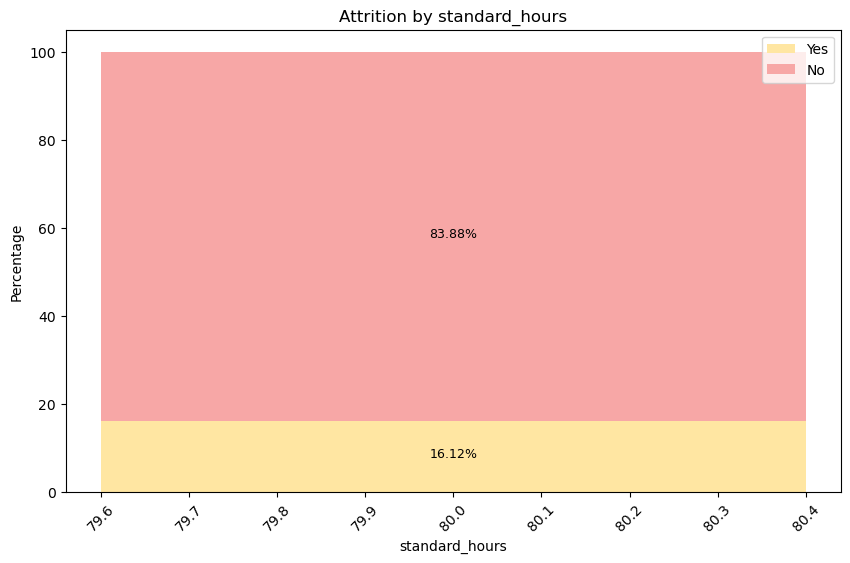

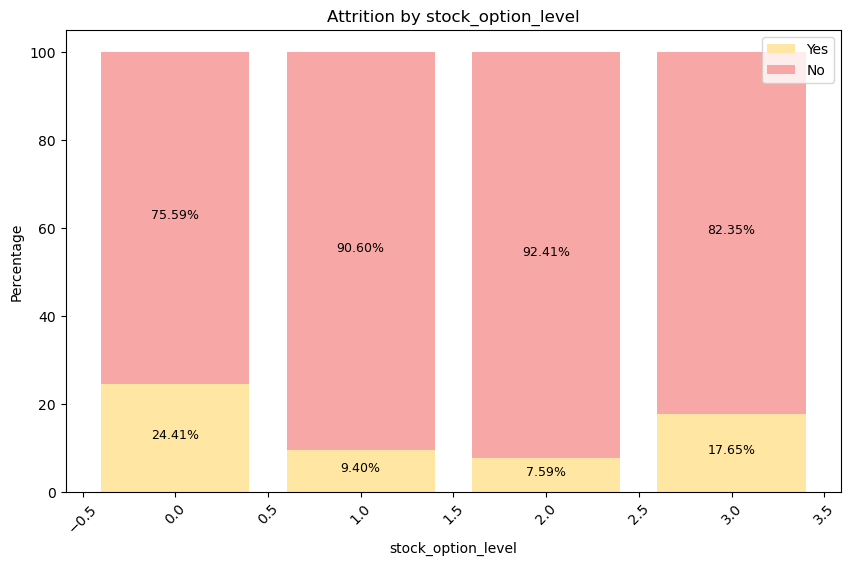

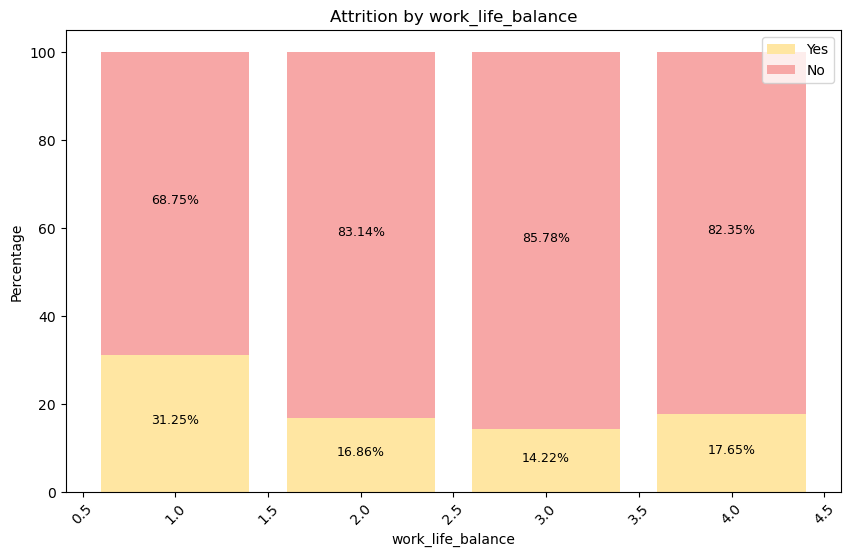

In [6]:
#Visualizing the Cross-tabulations
for result in cross_tabs:
    for var, table in result.items():
        plot_data = table.drop('Total')

        fig, ax = plt.subplots(figsize=(10, 6))

        ax.bar(plot_data.index, plot_data['Yes'], color='#FFE6A2', label='Yes')

        ax.bar(plot_data.index, plot_data['No'], color='#F7A7A6', label='No', bottom=plot_data['Yes'])

        plt.xlabel(var)
        plt.ylabel('Percentage')
        plt.title(f'Attrition by {var}')
        plt.legend()
        plt.xticks(rotation=45)
        ax.set_ylim(bottom=0)
        
        for container in ax.containers:
            ax.bar_label(container, label_type='center', fontsize=9, color='black', fmt='%.2f%%', padding=2)

        plt.show()

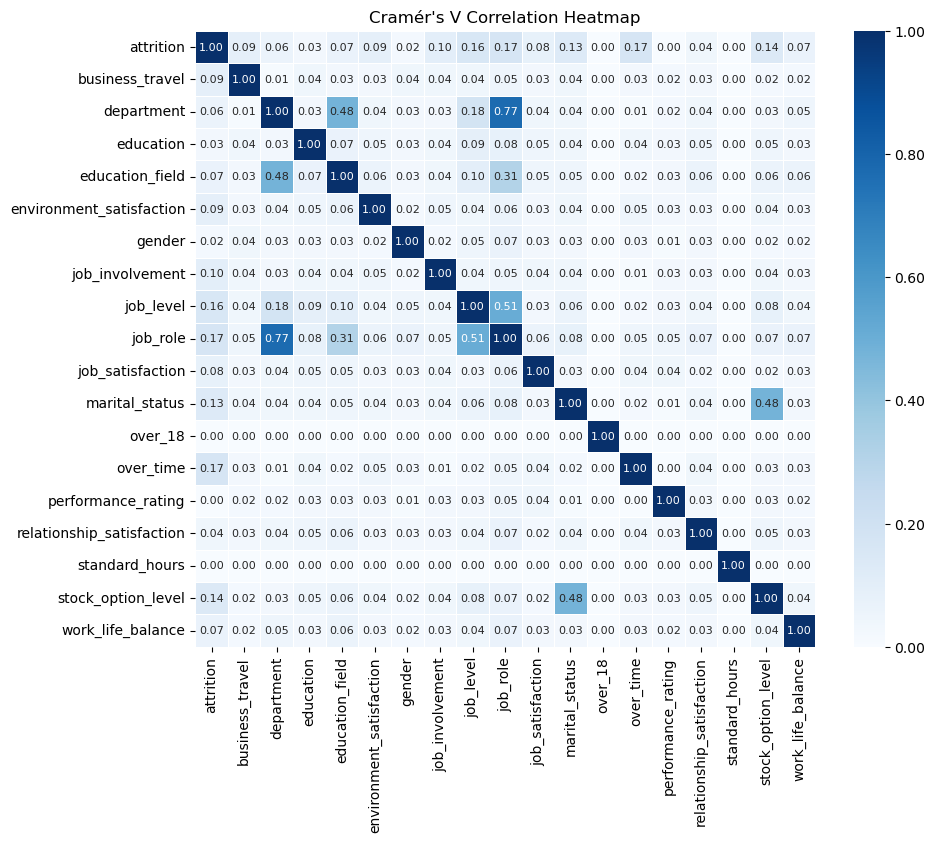

In [7]:
#Cramer's V Correlation Heatmap
def calculate_cramers_v_matrix(cat):
    columns = cat.columns
    n = len(cat)

    matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

    for col1 in columns:
        for col2 in columns:
            if col1 == col2:
                matrix.loc[col1, col2] = 1.0
            else:
                crosstab = pd.crosstab(cat[col1], cat[col2])
                chi2, _, _, _ = chi2_contingency(crosstab)
                v = np.sqrt(chi2 / (n * min(crosstab.shape) - 1))
                matrix.loc[col1, col2] = round(v, 2)

    return matrix

cramers_v_matrix = calculate_cramers_v_matrix(cat)

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap="Blues", linewidths=.5, cbar_kws={"format": "%.2f"}, annot_kws={"size": 8})

plt.title("Cramér's V Correlation Heatmap")
plt.show()